#Data Loading and Spliting

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
import time
import csv
from sklearn.dummy import DummyClassifier
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Import Datasets
!unzip -q '/content/drive/My Drive/APS360 Project/Breed_Group_Dataset.zip'
!unzip -q '/content/drive/My Drive/APS360 Project/Test Set.zip'

In [4]:
%%time
# Location of Datasets on Google Drive
train_path = '/content/Breed_Group_Dataset/'
test_path = '/content/Test Set/'

# Transform Settings
train_transform = transforms.Compose([transforms.CenterCrop((360,360)),
                                transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(15),
                                transforms.RandomAdjustSharpness(0.5, p=0.1),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
test_transform = transforms.Compose([transforms.CenterCrop((360,360)),
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
 
# Create full dataset
full_dataset = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
train_dataset = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(train_path, transform=test_transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=test_transform)


# Generate a function to obtain a subset of images
def get_subset(indices, start, end):
    return indices[start : start + end]

# Define the split ratio for training and validation
train_percentage, val_percentage = 0.8, 0.2
train_count = int(len(full_dataset) * train_percentage)
val_count = int(len(full_dataset) * val_percentage)
test_count = int(len(test_dataset))

# Obtain indices for each set's dataloader (won't be used for test)
indices = torch.randperm(len(full_dataset))
train_indices = get_subset(indices, 0, train_count)
val_indices = get_subset(indices, train_count, val_count)

CPU times: user 269 ms, sys: 21.9 ms, total: 291 ms
Wall time: 329 ms


#Training Code

In [6]:
def get_accuracy(model, data_loader):
  with torch.no_grad():
    correct = 0
    total = 0
    for imgs, labels in data_loader:
    
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
  return correct / total

In [9]:
def train(model, train_dataset, val_dataset, train_indices, val_indices, batch_size=64, learning_rate=0.001, num_epochs=1,weight_decay=0):
  
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=weight_decay)
  iters, losses, train_acc, val_acc = [], [], [], []

  # training
  epoch = 0 # the number of iterations
  start_time = time.time()
  for epoch in range(num_epochs):
    for imgs, labels in iter(train_loader):
      model.train(True)
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################
            
              
      out = model(imgs)             # forward pass
      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch


    # save the current training information
    iters.append(epoch)
    losses.append(float(loss)/batch_size) # compute *average* loss
    model.train(False)
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
    print("epoch number ", epoch+1, "accuracy: ",train_acc[epoch]) 
    val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
    model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), model_path)
       
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  
  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

#Main Model

In [8]:
#Load ResNet34
resnet34 = models.resnet34(pretrained=True)
num_ftrs = resnet34.fc.in_features

#Freeze convolutional network parameters
for param in resnet34.parameters():
    param.requires_grad = False

# Here the size of each output sample is set to 7 for our number of classes.
resnet34.name = 'ResNet34'
resnet34.fc = nn.Sequential(
            nn.Linear(num_ftrs , 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 7)
        )

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


CUDA is available!  Training on GPU ...
epoch number  1 accuracy:  0.7593882118875902
epoch number  2 accuracy:  0.7982467047998011
epoch number  3 accuracy:  0.8067644864461577
epoch number  4 accuracy:  0.8246083063914449
epoch number  5 accuracy:  0.8323178313852275
epoch number  6 accuracy:  0.836421288236757
epoch number  7 accuracy:  0.8459960208903258
epoch number  8 accuracy:  0.854700323302661
epoch number  9 accuracy:  0.8594876896294454
epoch number  10 accuracy:  0.8566277045511067
Finished Training
Total time elapsed: 2788.70 seconds


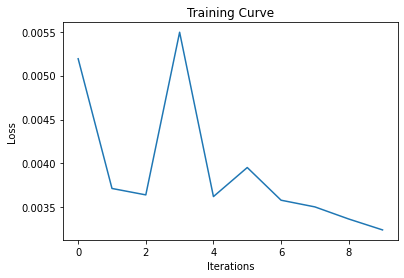

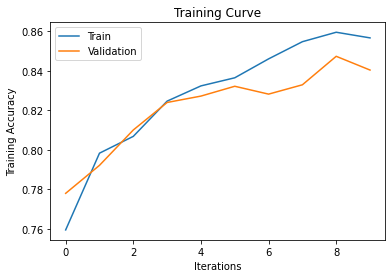

Final Training Accuracy: 0.8566277045511067
Final Validation Accuracy: 0.8403382243223079


In [10]:
use_cuda = True

model = resnet34

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#model
train(model, train_dataset, val_dataset, train_indices, val_indices, batch_size = 128 , learning_rate = 0.01, num_epochs=10, weight_decay=1e-7)

#Test

In [22]:
use_cuda = True

best_model = resnet34
#If testing new run (check epoch choice)
#best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("ResNet34",128, 0.01, 8)
#Load best model state
best_model_path = "/content/drive/MyDrive/APS360 Project/model_{0}_bs{1}_lr{2}_epoch{3}".format("ResNet34",128, 0.01, 8)
state = torch.load(best_model_path)
best_model.load_state_dict(state)
if use_cuda and torch.cuda.is_available():
    best_model.cuda()

best_model.train(False)

with torch.no_grad():
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, sampler=SubsetRandomSampler(val_indices))
  val_accuracy = get_accuracy(best_model, val_loader)
  print("Validation accuracy:", val_accuracy)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)
  test_accuracy = get_accuracy(best_model, test_loader)
  print("Test accuracy:", test_accuracy)

Validation accuracy: 0.8473016662521761
Test accuracy: 0.88



 Batch Accuracy: 90.0 %



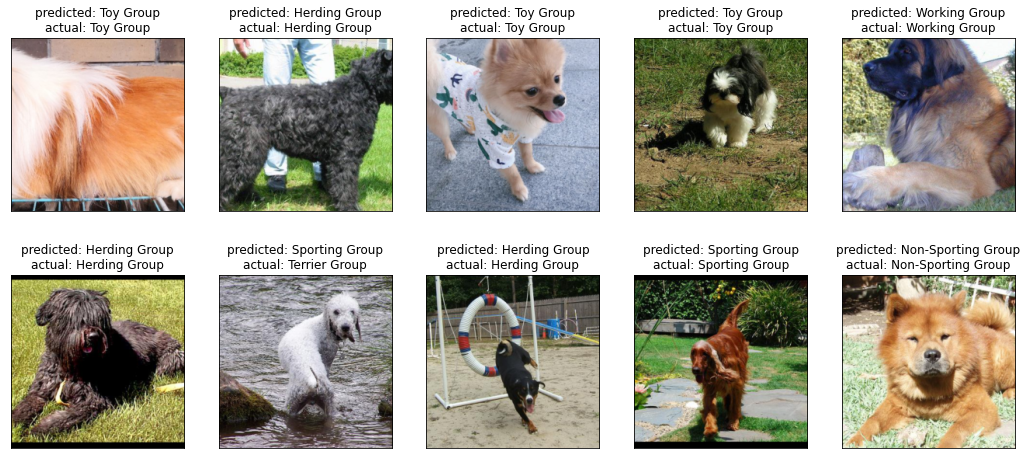

In [30]:
with torch.no_grad():
  best_model.train(False)

  #Data
  batch_size = 10
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

  #Get one batch of test images
  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  images = images.cuda()
  labels = labels.cuda()

  class_names = test_dataset.classes

  output = best_model(images)
  pred_labels = output.max(1, keepdim=True)[1]

  images = images.cpu()
  images = images.numpy()

  correct = 0
  total = batch_size

  #Plot the images in the batch
  fig = plt.figure(figsize=(18, 8))
  for idx in np.arange(batch_size):
    input = np.transpose(images[idx], (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.where(input<0, 0, input)
    input = np.where(input>1, 1, input)
    if pred_labels[idx] == labels[idx]:
      correct+=1
    

    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    plt.imshow(input)
    ax.set_title('predicted: {}\nactual: {}'.format(class_names[pred_labels[idx]],class_names[labels[idx]]))
  
  print("\n","Batch Accuracy:",correct/total*100,"%\n")